# Study donations made to DEM causes for the 2020 general election

## Preliminaries

Load data and define committees of interest:

In [3]:
# ruff: noqa
from decimal import Decimal
import datetime
from tqdm import tqdm


democrat_party = "DEM"

# IDs of FEC committees that are known to be *mostly* Democratic, even if they
# don't get reported that way in the FEC database. ActBlue is the key example:
# because they give to other not-strictly-DEM progressive groups, they're not
# marked as a DEM committee in the FEC database, but they're still a key
# Democratic fundraising tool.

KNOWN_DEM_COMMITTEE_IDS = {
    # ActBlue
    "C00401224": "ActBlue",
    # Biden Victory Fund
    "C00744946": "Biden Victory Fund",
    # MoveOn.org Political Action
    "C00341396": "MoveOn.org Political Action",
    # Golden Tennis Shoe PAC 2020
    "C00763003": "Golden Tennis Shoe PAC 2020",
    # The IMPACT Fund
    "C90020884": "The IMPACT Fund",
    # Washington Women for Choice
    "C00368332": "Washington Women for Choice",
    # Movement Voter PAC
    "C00728360": "Movement Voter PAC",
    # Fair Fight
    "C00693515": "Fair Fight",
    # EMILY's List
    "C00193433": "EMILY's List",
    # INDIVISIBLE Action
    "C00678839": "INDIVISIBLE Action",
    # National Democratic Redistricting PAC
    "C00630707": "National Democratic Redistricting PAC",
    # ONE FOR ALL Committee
    "C00752691": "ONE FOR ALL Committee",
}


class CommitteeColumns:
	ID = 0
	NAME = 1
	PARTY = 10
	

dem_committees: dict[str, str] = dict(KNOWN_DEM_COMMITTEE_IDS)

with open("../data/fec/committees-2020.txt") as f:
  for line in tqdm(f, total=18_287):
    line = line.strip().split("|")
    if line[CommitteeColumns.PARTY] == democrat_party:
      dem_committees[line[CommitteeColumns.ID]] = line[CommitteeColumns.NAME]

print(f"Found {len(dem_committees)} explicitly Democratic committees")

100%|██████████| 18287/18287 [00:00<00:00, 952597.40it/s]

Found 3158 explicitly Democratic committees


Load the full FEC individual contributions dataset for 2019/2020.

Filter out:

1. Anything outside of the Nov 2019 - Nov 2020 window (there are some random dates in the FEC dataset)
2. Anything indicating it's an amendment to a previous transaction (`AMNDT_IND in {"", "N"}`)
3. Anything that isn't explicitly for the 2020 general election (`TRANSACTION_PGI != G2020`)
4. Anything that isn't explicitly an individual donation (`ENTITY_TYPE != IND`)
5. Anything that isn't for an DEM committee (or a handful of known exceptions; see above)
6. Anything with weird dollar amounts <= $0


In [4]:
from dataclasses import dataclass

@dataclass(frozen=True)
class Contributor:
  """A 'unified key' for a single contributor. Imperfect, but so be it."""
  name: str
  city: str
  state: str
  employer: str
  occupation: str
  

class ContributionColumns:
  COMMITTEE_ID = 0
  AMNDT_IND = 1
  TRANSACTION_PGI = 3
  ENTITY_TYPE = 6
  NAME = 7
  CITY = 8
  STATE = 9
  EMPLOYER = 10
  OCCUPATION = 11
  TRANSACTION_DATE = 13
  TRANSACTION_AMOUNT = 14

contributions: list[tuple[Contributor, datetime.date, str, float]] = []
with open("../data/fec/individual-2020.txt") as f:
  for line in tqdm(f, total=70_659_611):
    splits = line.split("|")

    # 1. Only consider contributions from November 3, 2019 (inclusive) to November 3, 2020 (exclusive)
    try:
      date_str = splits[ContributionColumns.TRANSACTION_DATE]
      d = datetime.datetime.strptime(date_str, "%m%d%Y").date()
    except:
      continue
    if d < datetime.date(2019, 11, 3):
      continue
    if d >= datetime.date(2020, 11, 3):
      continue

    # 2. No amendments
    if splits[ContributionColumns.AMNDT_IND] not in {"", "N"}:
      continue

    # 3. General election contributions only
    if splits[ContributionColumns.TRANSACTION_PGI] != "G2020":
      continue

    # 4. Only consider individual contributions
    donating_entity_type = splits[ContributionColumns.ENTITY_TYPE]
    if donating_entity_type != "IND":
      continue

    # 5. Only consider contributions to known DEM committees
    committee_id = splits[ContributionColumns.COMMITTEE_ID]
    if committee_id not in dem_committees:
      continue

    # 6. Only consider contributions of > $0
    amount_usd = float(splits[ContributionColumns.TRANSACTION_AMOUNT])
    if amount_usd <= 0:
      continue

    # It's a keeper!
    contributor = Contributor(
      name=splits[ContributionColumns.NAME].upper().strip(),
      city=splits[ContributionColumns.CITY].upper().strip(),
      state=splits[ContributionColumns.STATE].upper().strip(),
      employer=splits[ContributionColumns.EMPLOYER].upper().strip(),
      occupation=splits[ContributionColumns.OCCUPATION].upper().strip(),
    )
    contributions.append((contributor, d, committee_id, amount_usd))

print(f"Found {len(contributions)} contributions")

100%|██████████| 70659611/70659611 [04:29<00:00, 262293.44it/s]

Found 4643882 contributions


Now, let's group the contributions by contributor, where "contributor" is defined by the Contributor class above -- basically, they have to have the same name, city, state, employer, and occupation.

In [5]:
by_contributor: dict[Contributor, list[tuple[datetime.date, str, float]]] = {}

for contributor, d, committee_id, amount_usd in tqdm(contributions):
  if contributor not in by_contributor:
    by_contributor[contributor] = []
  by_contributor[contributor].append((d, committee_id, amount_usd))

print(f"Found {len(by_contributor)} unique contributors")

100%|██████████| 4643882/4643882 [00:05<00:00, 808163.79it/s]

Found 1250295 unique contributors


# Weekly summaries

Count # and total $ of contributions by week (using the ISO week-of-the-year).

In [11]:
# Utility method
def get_start_date_of_iso_week(year, week_num):
    """Return the start date of an ISO week."""
    # Step 1: Find the first day of the year
    jan_1 = datetime.datetime(year, 1, 1)
    
    # Step 2: Determine the date of the first Thursday in the year
    # ISO weeks start on Monday, with the first week of the year containing the first Thursday.
    days_to_thursday = 3  # From Monday to Thursday
    first_thursday = jan_1 + datetime.timedelta(days=(3 - jan_1.weekday() + 7) % 7)
    
    # Step 3: Calculate the start date of the specified ISO week number
    # Subtract one week since the calculation includes the first week
    week_start_date = first_thursday + datetime.timedelta(weeks=week_num - 1) - datetime.timedelta(days=3)
    
    return week_start_date


# Count # and total $ of contributions by week (using the isocalendar() week number)
by_week_and_year: dict[datetime.date, tuple[int, float]] = {}

for contribution in tqdm(contributions):
  _, d, _, amount_usd = contribution
  year, week_num, _ = d.isocalendar()
  starting_date = get_start_date_of_iso_week(year, week_num)
  if starting_date not in by_week_and_year:
    by_week_and_year[starting_date] = (0, 0.0)
  count, total = by_week_and_year[starting_date]
  by_week_and_year[starting_date] = (count + 1, total + amount_usd)

# Order it into (date, count, total, weighted_avg) tuples, from earliest to latest date.
# Make sure things aren't nested.
by_week_and_year_ordered_nested = sorted(
  by_week_and_year.items(),
  key=lambda x: x[0]
)
by_week_and_year_ordered = [
  (date, count, total, total / count if count > 0 else 0.0)
  for date, (count, total) in by_week_and_year_ordered_nested
]

# Turn this into a pandas DataFrame
import pandas as pd
df = pd.DataFrame(by_week_and_year_ordered, columns=["week_starting", "count", "total_usd", "avg_usd"])
# Make sure each column has the right type
df["week_starting"] = pd.to_datetime(df["week_starting"])
df["count"] = df["count"].astype(int)
df["total_usd"] = df["total_usd"].astype(float)
df["avg_usd"] = df["avg_usd"].astype(float)

# Emit the DataFrame as a CSV
df.to_csv("../data/weekly-contributions-2020.csv", index=False)
print("Saved to ../data/weekly-contributions-2020.csv")

100%|██████████| 4643882/4643882 [00:09<00:00, 505675.05it/s]

Saved to ../data/weekly-contributions-2020.csv


### Graphing the weekly data!

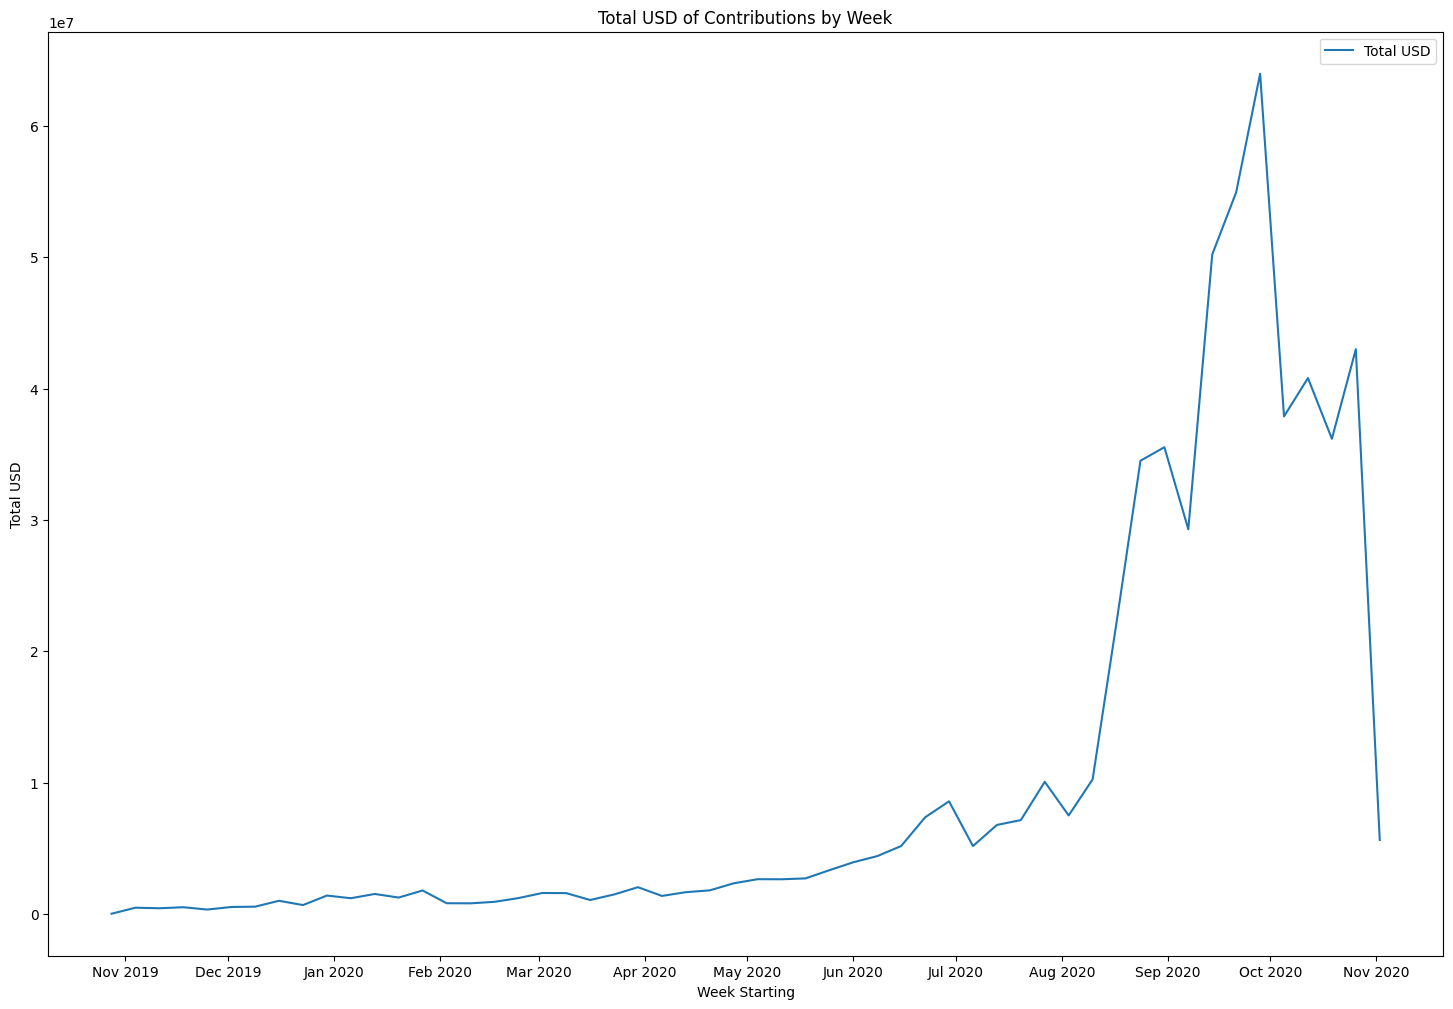

In [14]:
# First, let's graph the weekly total contributions by total_usd in a given week_starting

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()
# Make it bigger
fig.set_size_inches(18, 12)
ax.plot(df["week_starting"], df["total_usd"], label="Total USD")
ax.set_title("Total USD of Contributions by Week")
ax.set_xlabel("Week Starting")
ax.set_ylabel("Total USD")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.legend()
plt.show()


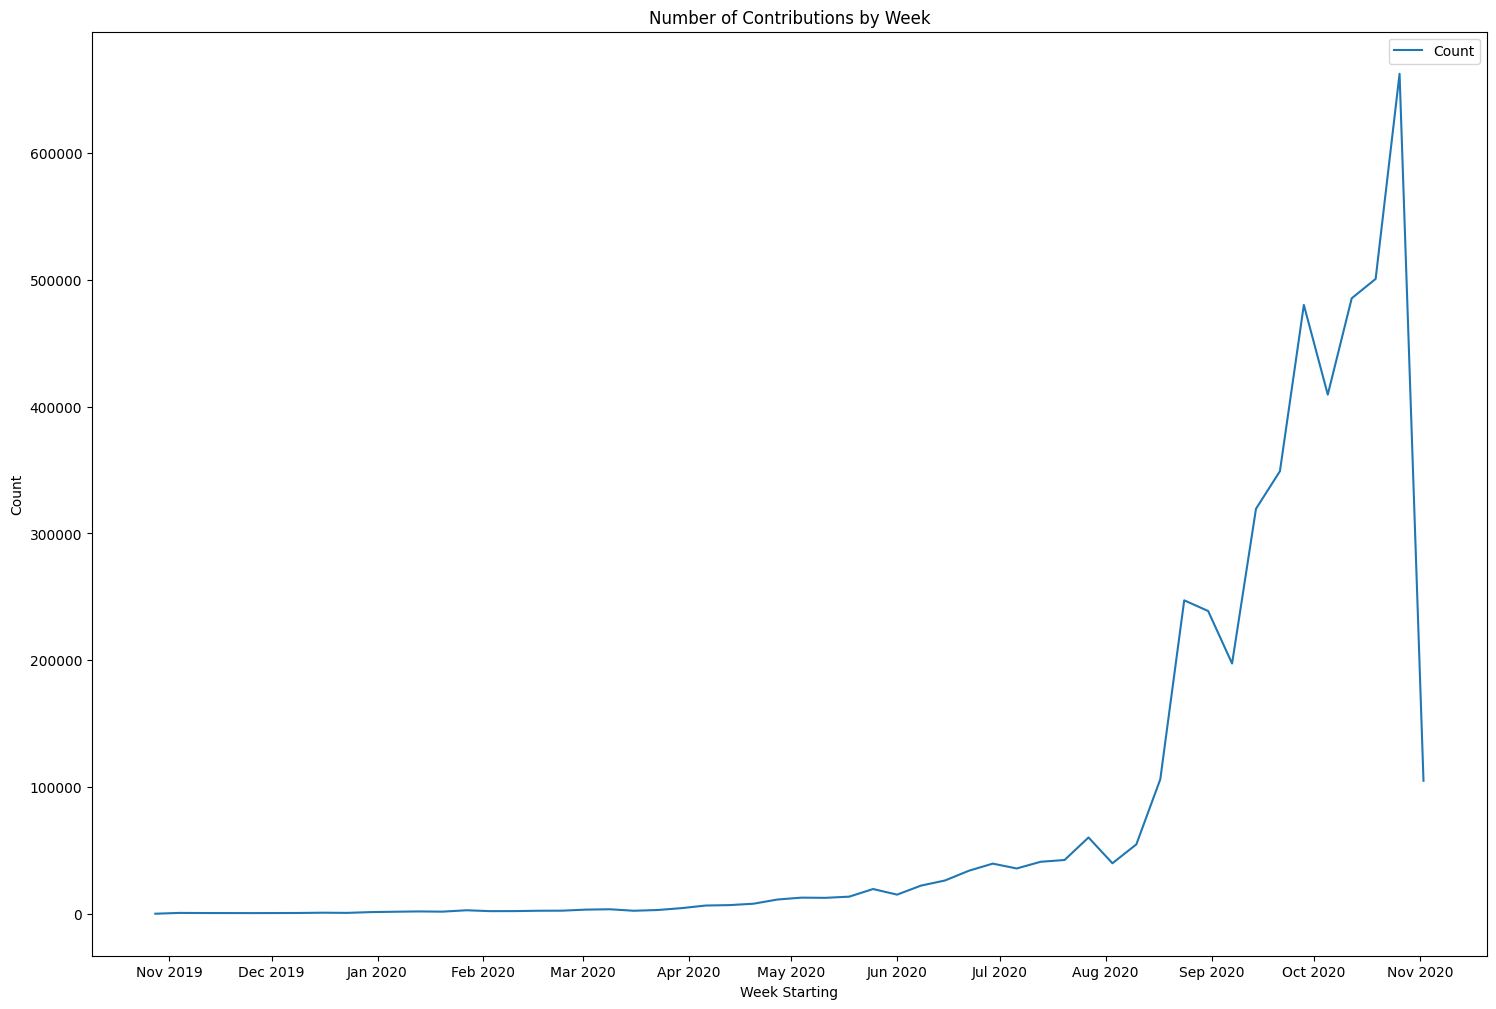

In [15]:
# Let's plot number of donations (`count`) by week
fig, ax = plt.subplots()
# Make it bigger
fig.set_size_inches(18, 12)
ax.plot(df["week_starting"], df["count"], label="Count")
ax.set_title("Number of Contributions by Week")
ax.set_xlabel("Week Starting")
ax.set_ylabel("Count")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.legend()
plt.show()


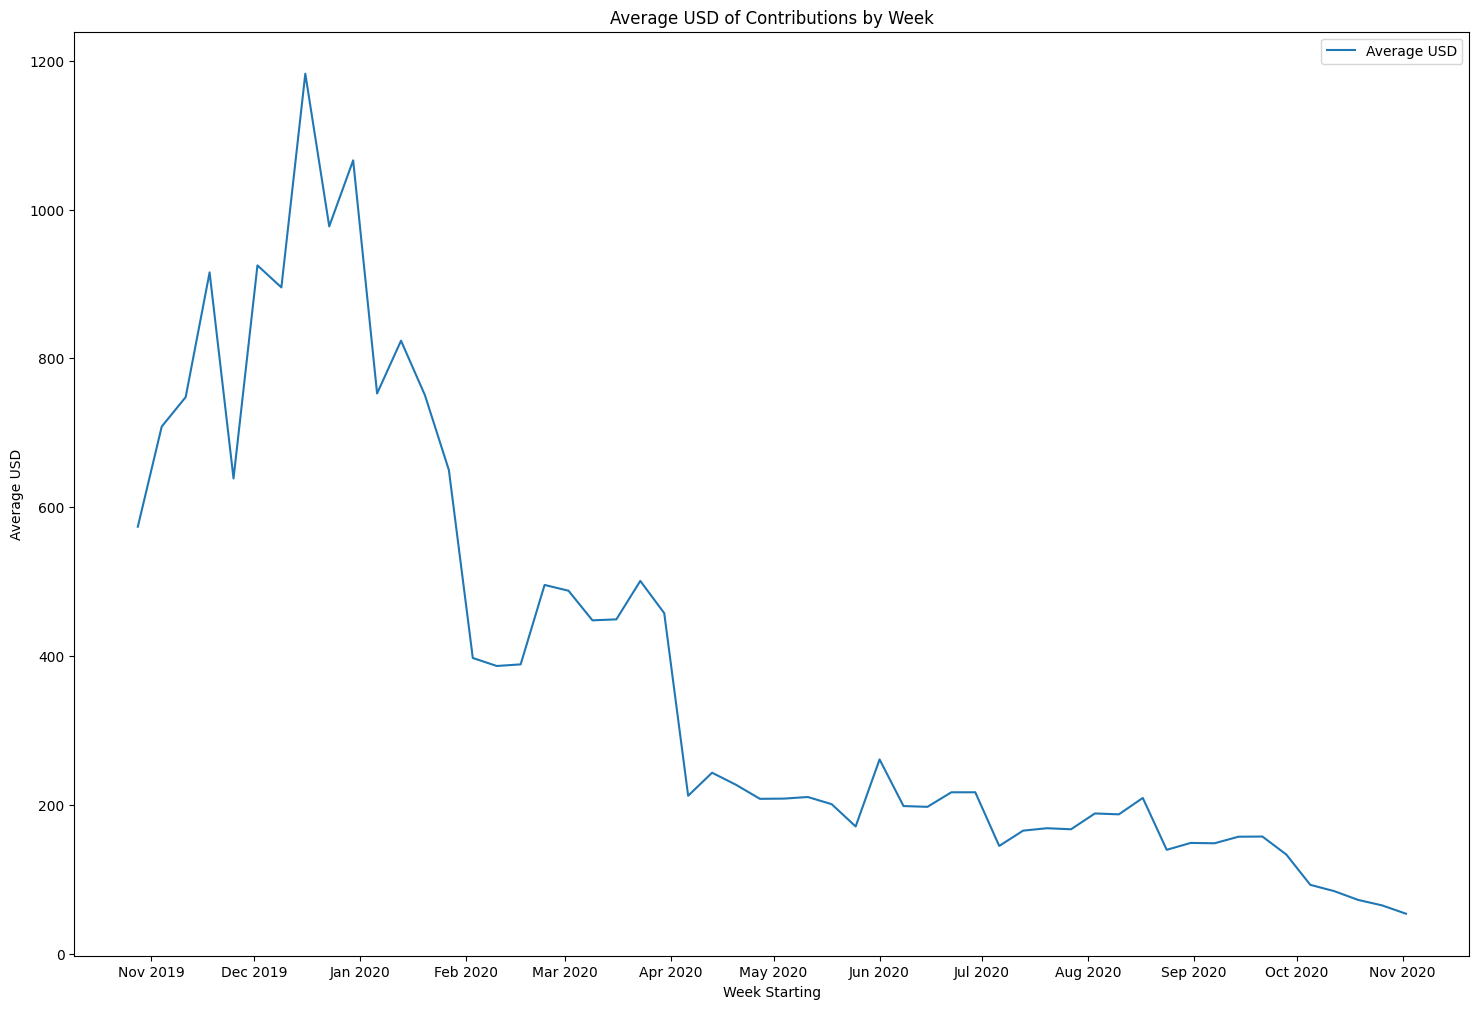

In [16]:
# And finally, by average contribution amount in a given week

fig, ax = plt.subplots()
# Make it bigger
fig.set_size_inches(18, 12)
ax.plot(df["week_starting"], df["avg_usd"], label="Average USD")
ax.set_title("Average USD of Contributions by Week")
ax.set_xlabel("Week Starting")
ax.set_ylabel("Average USD")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.legend()
plt.show()


## Big contributors

Let's define big contributors in a few different ways.

In [19]:
# Find all contributors who gave >= $100,000

big_100k_contributors: dict[Contributor, list[tuple[datetime.date, str, float]]] = {}
for contributor, contributions in tqdm(by_contributor.items()):
  total = sum(amount_usd for _, _, amount_usd in contributions)
  if total >= 100_000:
    big_100k_contributors[contributor] = contributions

# And again for $25k
big_25k_contributors: dict[Contributor, list[tuple[datetime.date, str, float]]] = {}
for contributor, contributions in tqdm(by_contributor.items()):
  total = sum(amount_usd for _, _, amount_usd in contributions)
  if total >= 25_000 and total < 100_000:
    big_25k_contributors[contributor] = contributions

# And again for $5k
big_5k_contributors: dict[Contributor, list[tuple[datetime.date, str, float]]] = {}
for contributor, contributions in tqdm(by_contributor.items()):
  total = sum(amount_usd for _, _, amount_usd in contributions)
  if total >= 5_000 and total < 25_000:
    big_5k_contributors[contributor] = contributions

print(f"Found {len(big_100k_contributors)} contributors who gave >= $100,000")
print(f"Found {len(big_25k_contributors)} contributors who gave >= $25,000")
print(f"Found {len(big_5k_contributors)} contributors who gave >= $5,000")

100%|██████████| 1250295/1250295 [00:01<00:00, 1050511.00it/s]

Found 8 contributors who gave >= $100,000
Found 332 contributors who gave >= $25,000
Found 7889 contributors who gave >= $5,000
